In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
import cv2
import os

Mounted at /content/drive


In [2]:
from tensorflow import keras

@keras.utils.register_keras_serializable()
class BinaryF1(keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]) >= self.threshold, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1.0 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1.0 - y_pred))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall    = self.tp / (self.tp + self.fn + 1e-8)
        return 2.0 * precision * recall / (precision + recall + 1e-8)

    def reset_state(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(0.0)


In [3]:

model_paths = {
    "EfficientNetB0": "/content/drive/MyDrive/BestModels/best_efficientnetb0.keras",
    "ResNet50": "/content/drive/MyDrive/BestModels/best_resnet50.keras",
    "Xception": "/content/drive/MyDrive/BestModels/best_xception.keras"
}

custom_objects = {"BinaryF1": BinaryF1}

models = {
    name: keras.models.load_model(path, custom_objects=custom_objects)
    for name, path in model_paths.items()
}

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 220 variables whereas the saved optimizer has 224 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 198 variables whereas the saved optimizer has 202 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 196 variables whereas the saved optimizer has 200 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
test_folder = "/content/drive/MyDrive/TestSamples/"
image_names = sorted(os.listdir(test_folder))[:5]

true_labels = ["Fake", "Fake", "Fake", "Real", "Real"]

input_sizes = {
    "EfficientNetB0": (224, 224),
    "ResNet50": (256, 256),
    "Xception": (224, 224)
}

def load_and_resize(path, size):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    img = img.astype("float32") / 255.0
    return img

RESULTS FOR 5 TEST IMAGES

---- EfficientNetB0 ----


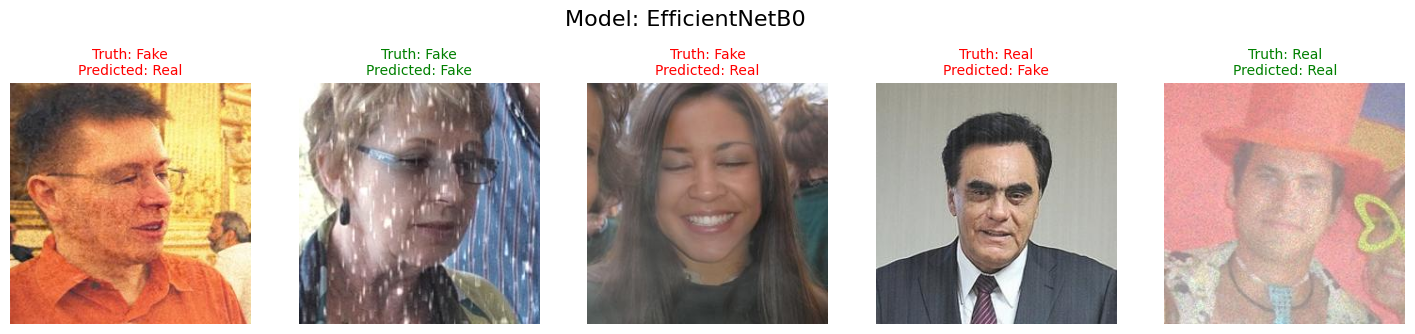



---- ResNet50 ----


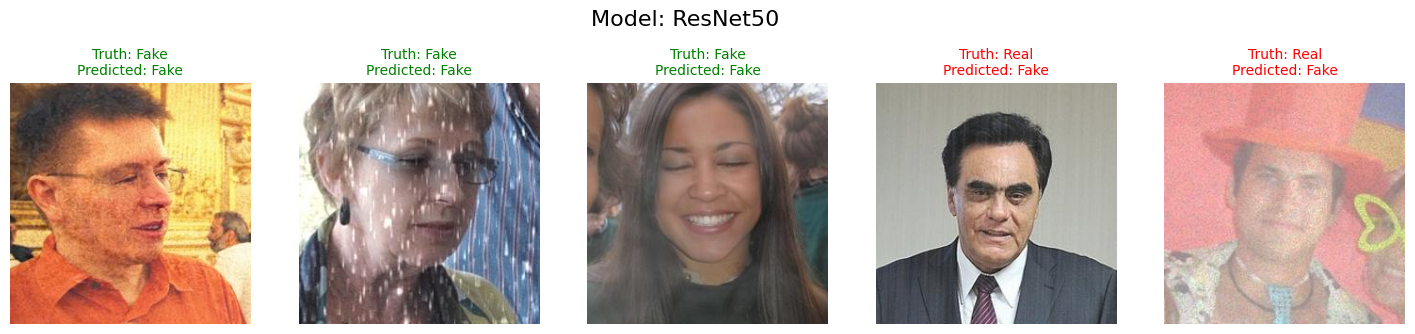



---- Xception ----


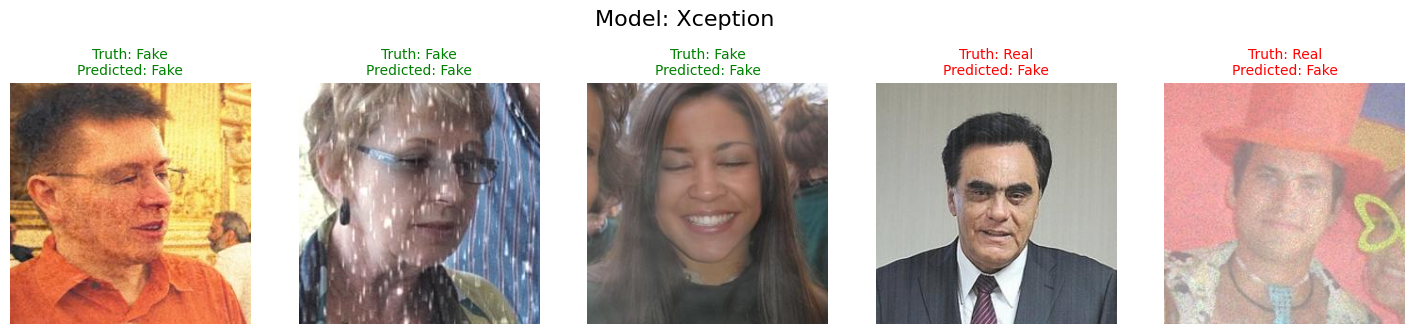

In [37]:
import matplotlib.pyplot as plt

def get_label(prob):
    return "Fake" if prob > 0.5 else "Real"

print("RESULTS FOR 5 TEST IMAGES\n")

for model_name, model in models.items():
    print(f"---- {model_name} ----")

    resized_images = []
    original_images = []

    for img_name in image_names:
        img_path = os.path.join(test_folder, img_name)


        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        original_images.append(img_original)

        # Resize for the model
        size = input_sizes[model_name]
        resized_images.append(load_and_resize(img_path, size))

    resized_images = np.array(resized_images)
    preds = model.predict(resized_images, verbose=0)

    plt.figure(figsize=(18, 4))

    for i, p in enumerate(preds):
        predicted_label = get_label(p[0])

        plt.subplot(1, 5, i+1)
        plt.imshow(original_images[i])
        plt.axis("off")
        plt.title(
            f"Truth: {true_labels[i]}\nPredicted: {predicted_label}",
            fontsize=10,
            color=("green" if true_labels[i] == predicted_label else "red")
        )

    plt.suptitle(f"Model: {model_name}", fontsize=16)
    plt.show()
    print("\n")
